In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tqdm import tqdm

# Đường dẫn tới dữ liệu đã phân chia
DATA_DIR = Path("data/splits")
PROCESSED_DIR = Path("data/processed")
AUGMENTED_DIR = Path("data/augmented")
CLASSES = ["Brown_Spot", "Leaf_Blast", "Leaf_Blight", "Healthy"]
SPLITS = ["train", "val", "test"]

# Kích thước chuẩn hóa ảnh - dựa trên phân tích kích thước trung bình (241x241)
TARGET_SIZE = (224, 224)  # Kích thước phổ biến cho nhiều mô hình CNN

In [8]:
def augment_data():
    """Tăng cường dữ liệu cho tập train với nhiều phương pháp đa dạng"""
    # Chỉ tăng cường dữ liệu cho tập train
    src_dir = PROCESSED_DIR / "train"
    dst_dir = AUGMENTED_DIR / "train"
    
    # Sao chép dữ liệu val và test từ processed sang augmented
    for split in ["val", "test"]:
        for cls in CLASSES:
            src = PROCESSED_DIR / split / cls
            dst = AUGMENTED_DIR / split / cls
            if src.exists():
                for file in src.glob("*"):
                    shutil.copy2(file, dst / file.name)
    
    # Thiết lập ImageDataGenerator với nhiều phương pháp tăng cường hơn
    datagen = ImageDataGenerator(
        rotation_range=30,               # Tăng phạm vi xoay
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,             # Không lật dọc vì không phù hợp với lá cây
        brightness_range=[0.8, 1.2],     # Thay đổi độ sáng
        channel_shift_range=0.1,         # Thay đổi kênh màu nhẹ
        fill_mode='nearest'
    )
    
    # Đếm số lượng ảnh mỗi lớp để cân bằng dữ liệu
    class_counts = {}
    for cls in CLASSES:
        class_counts[cls] = len(list((src_dir / cls).glob("*")))
    
    max_count = max(class_counts.values())
    print(f"Số lượng ảnh lớp lớn nhất: {max_count}")
    
    # Tăng cường dữ liệu cho mỗi lớp
    for cls in CLASSES:
        src_class_dir = src_dir / cls
        dst_class_dir = dst_dir / cls
        
        # Sao chép ảnh gốc
        for file in src_class_dir.glob("*"):
            shutil.copy2(file, dst_class_dir / file.name)
        
        # Tính số lượng ảnh cần tạo thêm
        n_to_generate = max_count - class_counts[cls]
        if n_to_generate <= 0:
            print(f"Lớp {cls} đã có đủ dữ liệu ({class_counts[cls]} ảnh)")
            continue
            
        print(f"Tạo thêm {n_to_generate} ảnh cho lớp {cls}")
        
        # Đọc tất cả ảnh vào bộ nhớ
        images = []
        for file in src_class_dir.glob("*"):
            img = cv2.imread(str(file))
            if img is not None:
                img = cv2.resize(img, TARGET_SIZE)
                images.append(img)
        
        if not images:
            continue
            
        # Chuyển đổi thành numpy array
        images = np.array(images)
        
        # Tạo ảnh mới
        generated_count = 0
        batch_size = min(32, len(images))
        
        for x_batch in datagen.flow(
            images, 
            batch_size=batch_size,
            save_to_dir=str(dst_class_dir),
            save_prefix=f'aug_{cls}',
            save_format='jpg'
        ):
            generated_count += batch_size
            if generated_count >= n_to_generate:
                break
    
    print("Hoàn thành tăng cường dữ liệu")

def visualize_augmentation():
    """Hiển thị một số ảnh đã tăng cường"""
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(CLASSES):
        # Tìm các ảnh tăng cường
        aug_files = list((AUGMENTED_DIR / "train" / cls).glob("aug_*"))
        if not aug_files or len(aug_files) < 5:
            continue
            
        # Hiển thị 5 ảnh tăng cường
        for j, img_path in enumerate(aug_files[:5]):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(CLASSES), 5, i*5 + j + 1)
            plt.imshow(img)
            if j == 0:
                plt.title(f"{cls}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('augmented_samples.png')
    plt.show()

def analyze_dataset_balance():
    """Phân tích sự cân bằng của dữ liệu sau khi tăng cường"""
    counts = {}
    
    # Đếm số lượng ảnh trong dữ liệu gốc
    counts["original"] = {}
    for cls in CLASSES:
        counts["original"][cls] = len(list((DATA_DIR / "train" / cls).glob("*")))
    
    # Đếm số lượng ảnh trong dữ liệu đã xử lý
    counts["processed"] = {}
    for cls in CLASSES:
        counts["processed"][cls] = len(list((PROCESSED_DIR / "train" / cls).glob("*")))
    
    # Đếm số lượng ảnh trong dữ liệu đã tăng cường
    counts["augmented"] = {}
    for cls in CLASSES:
        counts["augmented"][cls] = len(list((AUGMENTED_DIR / "train" / cls).glob("*")))
    
    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(CLASSES))
    width = 0.25
    
    plt.bar(x - width, [counts["original"][cls] for cls in CLASSES], width, label='Gốc')
    plt.bar(x, [counts["processed"][cls] for cls in CLASSES], width, label='Đã xử lý')
    plt.bar(x + width, [counts["augmented"][cls] for cls in CLASSES], width, label='Đã tăng cường')
    
    plt.xlabel('Lớp')
    plt.ylabel('Số lượng ảnh')
    plt.title('So sánh số lượng ảnh trước và sau khi xử lý')
    plt.xticks(x, CLASSES)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('dataset_balance.png')
    plt.close()
    
    # In thông tin
    print("\n===== THỐNG KÊ SỐ LƯỢNG ẢNH =====")
    for dataset in ["original", "processed", "augmented"]:
        total = sum(counts[dataset].values())
        print(f"\nDữ liệu {dataset}:")
        for cls in CLASSES:
            count = counts[dataset][cls]
            percentage = (count / total) * 100
            print(f"  {cls}: {count} ảnh ({percentage:.1f}%)")
        print(f"  Tổng cộng: {total} ảnh")

In [5]:
augment_data()

Số lượng ảnh lớp lớn nhất: 890
Tạo thêm 14 ảnh cho lớp Brown_Spot
Tạo thêm 22 ảnh cho lớp Leaf_Blast
Lớp Leaf_Blight đã có đủ dữ liệu (890 ảnh)
Tạo thêm 19 ảnh cho lớp Healthy
Hoàn thành tăng cường dữ liệu


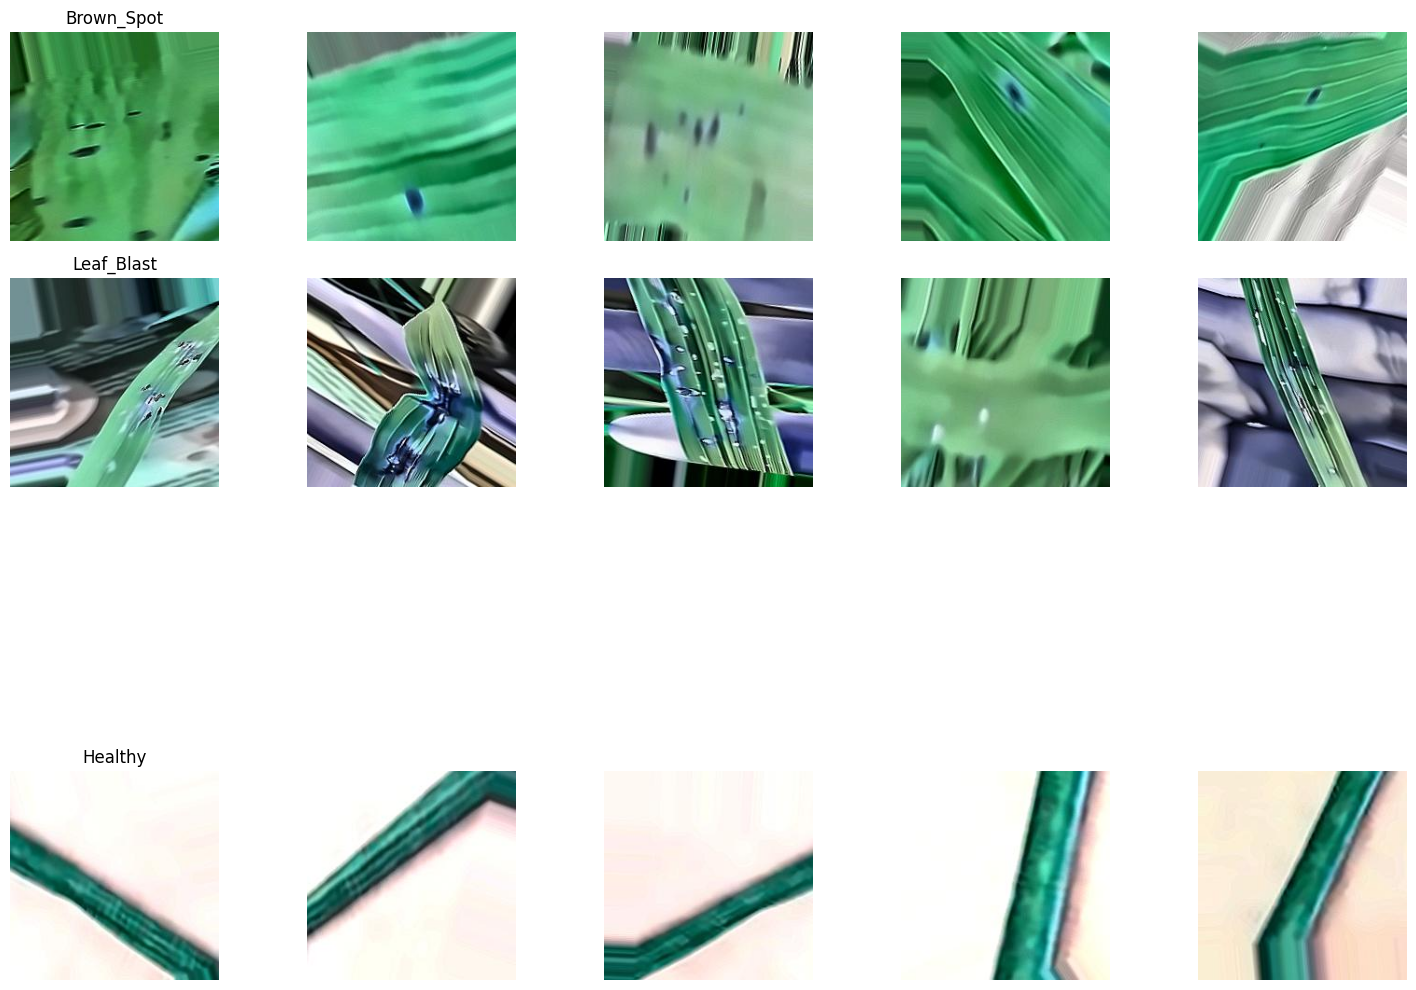

In [9]:
visualize_augmentation()

In [10]:
analyze_dataset_balance()



===== THỐNG KÊ SỐ LƯỢNG ẢNH =====

Dữ liệu original:
  Brown_Spot: 876 ảnh (25.0%)
  Leaf_Blast: 868 ảnh (24.8%)
  Leaf_Blight: 890 ảnh (25.4%)
  Healthy: 871 ảnh (24.9%)
  Tổng cộng: 3505 ảnh

Dữ liệu processed:
  Brown_Spot: 876 ảnh (25.0%)
  Leaf_Blast: 868 ảnh (24.8%)
  Leaf_Blight: 890 ảnh (25.4%)
  Healthy: 871 ảnh (24.9%)
  Tổng cộng: 3505 ảnh

Dữ liệu augmented:
  Brown_Spot: 908 ảnh (25.2%)
  Leaf_Blast: 900 ảnh (25.0%)
  Leaf_Blight: 890 ảnh (24.7%)
  Healthy: 903 ảnh (25.1%)
  Tổng cộng: 3601 ảnh
